# Clustering Analysis


## Geographical Clustering

1. We want to cluster the states based on the number of incidents per state. We will use the K-Means algorithm.
2. We can explore if some regions or states have similar incidents characteristics.

In [1]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load the h5
df_merged_clustering_reduced = pd.read_hdf('../../ds/cleaned/reduced_for_clustering.h5')

In [3]:
df_merged_clustering_reduced.info()
df_merged_clustering_reduced['avg_incident_density_per_district'] = df_merged_clustering_reduced.groupby('congressional_district')['density_incident_state'].transform('mean')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 131618 entries, 0 to 134578
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       131618 non-null  datetime64[ns]
 1   state                      131618 non-null  object        
 2   city_or_county             131618 non-null  object        
 3   latitude                   131618 non-null  float64       
 4   longitude                  131618 non-null  float64       
 5   congressional_district     131618 non-null  int64         
 6   participant_age_group1     131618 non-null  category      
 7   participant_gender1        131618 non-null  category      
 8   avg_age_participants       131618 non-null  int64         
 9   n_participants_child       131618 non-null  int64         
 10  n_participants_teen        131618 non-null  int64         
 11  n_females                  131618 non-null  int64   

In [4]:
df_merged_clustering_reduced.describe()

,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,povertyPercentage,candidatevotes,totalvotes,ratio_killed,percentage_injured,unharmed_ratio,density_incident_state,males_to_females_ratio,avg_incident_density_per_district
count,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000,131618.000000
mean,37.857413,-88.869912,7.825495,30.192474,0.021828,0.132573,0.207031,0.344846,0.480884,0.528514,0.368293,1.730888,12.561100,164455.640186,244280.492547,0.217788,58.284703,7.249900,0.406661,1.515627,0.406661
std,5.105932,14.190983,8.148107,12.510064,0.163032,0.415659,0.452418,0.545520,0.627835,0.721967,0.718189,0.841162,2.744852,55958.305297,80048.336332,0.359383,11.620417,2.859830,0.265269,0.827900,0.117151
min,19.111400,-171.429000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.400000,0.000000,0.000000,0.000000,34.816248,2.345189,0.000000,0.000000,0.271355
25%,34.123025,-92.374850,2.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.700000,124779.000000,182278.000000,0.000000,48.335855,6.948837,0.235904,1.000000,0.317587
50%,39.058800,-86.251400,5.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,12.200000,164355.000000,246243.000000,0.000000,57.169460,7.498870,0.389732,1.000000,0.344431
75%,41.689400,-79.874050,10.000000,36.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,14.100000,205647.000000,308198.000000,0.500000,64.576154,10.512655,0.580850,2.000000,0.518333
max,71.336800,-67.275000,53.000000,96.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,20.800000,329800.000000,507831.000000,1.000000,84.868421,10.512655,1.000000,4.000000,0.759406


# Feature selection for clustering

We will try more clusters from the indexes we gathered in previous analysis

In [5]:
# Initially we select all the


selected_features_old = df_merged_clustering_reduced[['percentage_injured', 
                                                  'unharmed_ratio',
                                                  'males_to_females_ratio', 
                                                   'povertyPercentage',
                                                  'avg_incident_density_per_district', 
                                                  'density_incident_state', 
                                                  'avg_age_participants', 
                                                  'congressional_district','totalvotes']]


selected_features = df_merged_clustering_reduced[['percentage_injured', 'unharmed_ratio',
                                                  'males_to_females_ratio', 
                                                  'totalvotes', 'povertyPercentage',
                                                  'density_incident_state', 'avg_age_participants', 'congressional_district']]


selected_features_demographic = df_merged_clustering_reduced[['avg_age_participants', 'n_arrested', 'density_incident_state']]



## PCA for dimensionality reduction

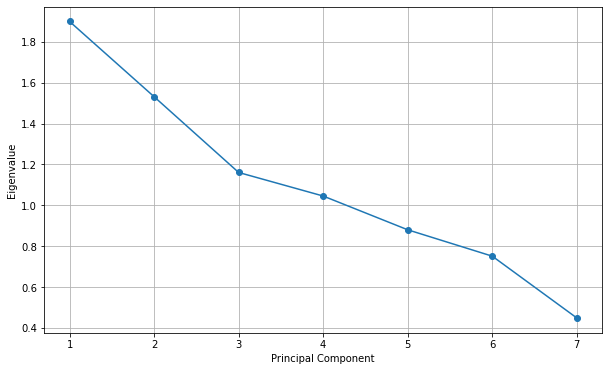

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(selected_features)
# gettin dataset for clustering
df_scaled_clustering = pd.DataFrame(X_scaled, columns=selected_features.columns)

pca = PCA(n_components=7)
X_pca = pca.fit(X_scaled)

# getting eigenvalues and eigenvectors

eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

explained_variance_ratio = pca.explained_variance_ratio_

# Screeplot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
#add grid
plt.grid()
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()




In [7]:
selected_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131618 entries, 0 to 134578
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   percentage_injured      131618 non-null  float64
 1   unharmed_ratio          131618 non-null  float64
 2   males_to_females_ratio  131618 non-null  float64
 3   totalvotes              131618 non-null  float64
 4   povertyPercentage       131618 non-null  float64
 5   density_incident_state  131618 non-null  float64
 6   avg_age_participants    131618 non-null  int64  
 7   congressional_district  131618 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 9.0 MB


In [8]:
df_scaled_clustering.describe()

,percentage_injured,unharmed_ratio,males_to_females_ratio,totalvotes,povertyPercentage,density_incident_state,avg_age_participants,congressional_district
count,1.316180e+05,1.316180e+05,1.316180e+05,1.316180e+05,1.316180e+05,1.316180e+05,1.316180e+05,1.316180e+05
mean,4.461339e-16,-5.882230e-16,-4.802661e-16,3.096053e-17,4.806844e-16,1.299694e-17,-1.268653e-17,-6.036898e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.019596e+00,-1.715042e+00,-1.830696e+00,-3.051674e+00,-2.608930e+00,-1.533019e+00,-2.333528e+00,-8.376818e-01
25%,-8.561557e-01,-1.052735e-01,-6.228159e-01,-7.745661e-01,-6.780355e-01,-6.437131e-01,-7.348091e-01,-7.149534e-01
50%,-9.597312e-02,8.705778e-02,-6.228159e-01,2.451662e-02,-1.315560e-01,-6.381610e-02,-2.551934e-01,-3.467684e-01
75%,5.414156e-01,1.140896e+00,5.850641e-01,7.984894e-01,5.606515e-01,6.566566e-01,4.642301e-01,2.668734e-01
max,2.287682e+00,1.140896e+00,3.000824e+00,3.292405e+00,3.001594e+00,2.236756e+00,5.260387e+00,5.544193e+00


In [9]:

#entropy of each feature
from scipy.stats import entropy
for col in selected_features.columns:
    print(col, entropy(selected_features[col].value_counts(normalize=True)))


percentage_injured 3.508907485788771
unharmed_ratio 1.5061390716861425
males_to_females_ratio 1.1784182832930683
totalvotes 6.512642166060452
povertyPercentage 4.187976388641285
density_incident_state 3.508907485788771
avg_age_participants 3.7726701616052374
congressional_district 2.9422204622544403


## Considering the 2 principal components


In [10]:
pca_clustering = PCA(n_components = 2)
pca_clustering_3 = PCA(n_components = 3)

principal_components = pca_clustering.fit_transform(X_scaled)
principal_components_3 = pca_clustering_3.fit_transform(X_scaled)
# transform original dataframe with the new components
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
df_pca_3 = pd.DataFrame(principal_components_3, columns=['PC1', 'PC2', 'PC3'])

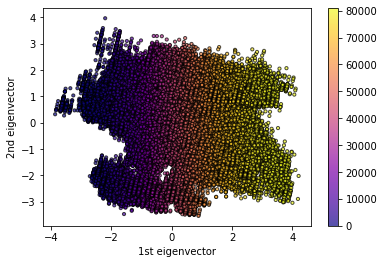

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set color palette for PC1, PC2, PC3
sns.set_palette('Set1', n_colors=3)

# Create scatter plot
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], edgecolor='k', s=10, alpha=0.7, 
                      cmap=plt.get_cmap('plasma'), 
                      c=df_pca['PC1'].astype('category').cat.codes)
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
# Add a color bar

plt.colorbar(scatter)

plt.show()

# Showing first three components

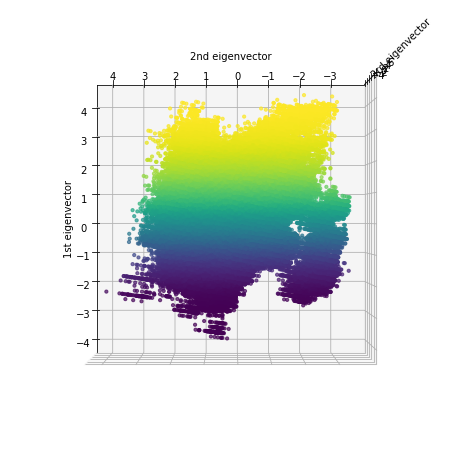

In [12]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca_3['PC1'], df_pca_3['PC2'], df_pca_3['PC3'], s=10, alpha=0.7, 
           c=df_pca_3['PC1'].astype('category').cat.codes)
# change angle
ax.view_init(90, 185)
ax.set_xlabel('1st eigenvector')
ax.set_ylabel('2nd eigenvector')
ax.set_zlabel('3rd eigenvector')
plt.show()

## Running K-means now

100%|██████████| 9/9 [00:19<00:00,  2.14s/it]


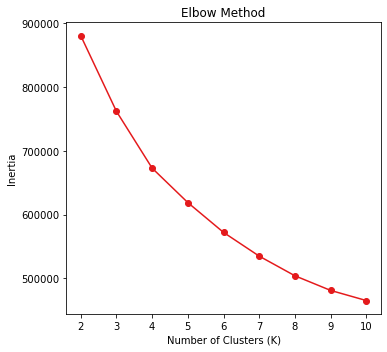

Text(0.5, 1.0, 'Silhouette Method')

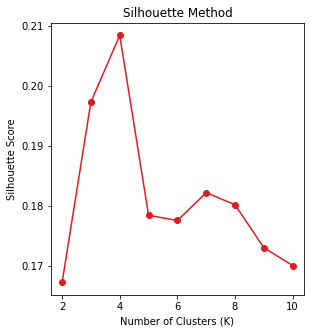

In [13]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
models = []

for k in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10, max_iter=100)
    kmeans.fit(df_scaled_clustering)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled_clustering, kmeans.labels_, sample_size=5000))
    models.append(kmeans)
# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.tight_layout()
plt.show()

# plot the silhouette scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')


In [14]:
# do a table with each value for silohuette and inertia and the number of clusters
results = pd.DataFrame({'inertia': inertia, 'silhouette': silhouette_scores}, index=range(2, 11))
results['clusters'] = results.index
results


,inertia,silhouette,clusters
2,880540.265096,0.167206,2
3,761911.428534,0.197324,3
4,672841.692816,0.208415,4
5,618838.376591,0.178411,5
6,572091.508638,0.177539,6
7,534870.515315,0.182181,7
8,504089.866597,0.180171,8
9,481157.088998,0.172995,9
10,465269.905288,0.170027,10


/home/vincent/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

/home/vincent/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

/home/vincent/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

/home/vincent/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

/home/vincent/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

/home/vincent/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

/home/vincent/.l

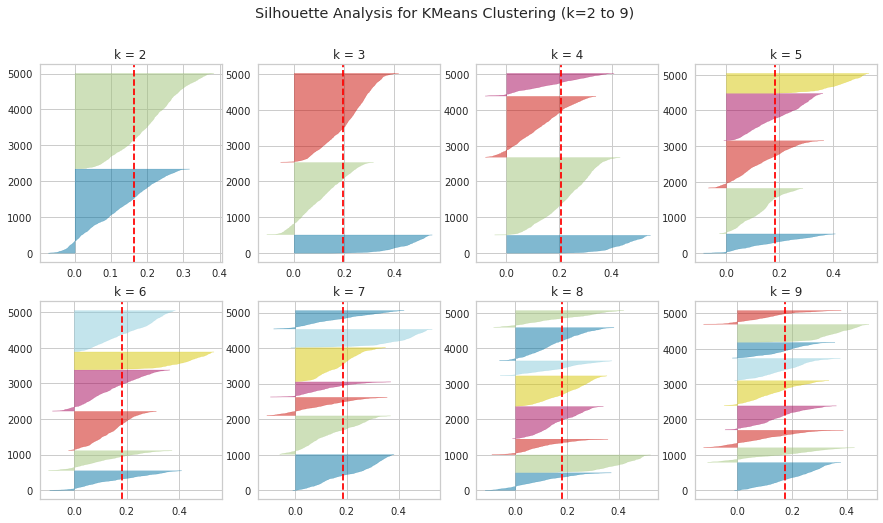

In [15]:
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

# Assuming you have a list of kmeans models named 'models' for k values 2 to 9
# models = [kmeans_2, kmeans_3, ..., kmeans_9]

fig, axs = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Silhouette Analysis for KMeans Clustering (k=2 to 9)')

for i in range(2, 10):
    kmeans = models[i-2]  # models list is 0-indexed
    row = (i-2) // 4
    col = (i-2) % 4

    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axs[row, col])
    visualizer.fit(df_scaled_clustering.sample(5000))
    axs[row, col].set_title(f'k = {i}')

plt.show()


/home/vincent/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=100, n_clusters=4, n_init=10,
                                      random_state=42))

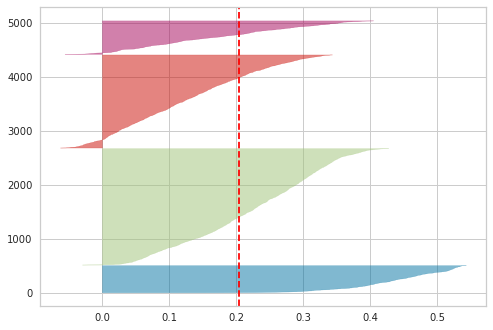

In [16]:
# Visualizing silohuette
from yellowbrick.cluster import SilhouetteVisualizer
# take cluster with 4

kmeans_4 = models[2]
visualizer = SilhouetteVisualizer(kmeans_4, colors='yellowbrick', ax=plt.gca())

visualizer.fit(df_scaled_clustering.sample(5000))

In [17]:
# Choose the optimal K and fit the KMeans model
optimal_k = 4# Adjust based on your analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
#sample same data as above
df_merged = df_merged_clustering_reduced.copy()
df_merged['cluster'] = kmeans.fit_predict(df_scaled_clustering)

df_merged['cluster_kmeans'] = kmeans.labels_
df_merged['cluster_kmeans'].value_counts()
df_merged['cluster_2'] = kmeans.labels_


/home/vincent/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



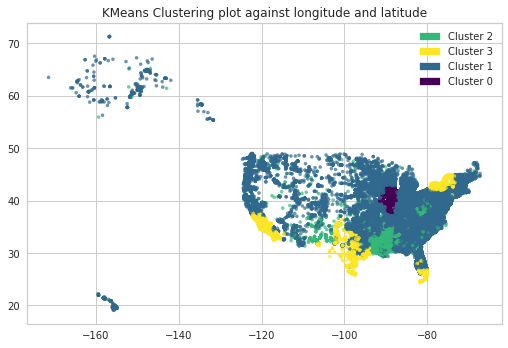

In [18]:
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)

# Get the unique clusters
clusters = df_merged['cluster'].unique()

# Create a colormap
cmap = plt.cm.viridis

# Normalize the colormap
norm = plt.Normalize(df_merged['cluster'].min(), df_merged['cluster'].max())

# Create a scatter plot
sc = plt.scatter(df_merged['longitude'], df_merged['latitude'], c=df_merged['cluster'], cmap='viridis', s=10, alpha=0.7)

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cmap(norm(cluster)), label=f'Cluster {cluster}') for cluster in clusters]

# Add the legend to the plot
plt.legend(handles=patches)

plt.title('KMeans Clustering plot against longitude and latitude')
plt.tight_layout()
plt.show()

# Poverty and clusters

Cluster 2 has a poverty percentage of 14.5850368129546
Cluster 3 has a poverty percentage of 13.13286484521718
Cluster 1 has a poverty percentage of 11.158325300993672
Cluster 0 has a poverty percentage of 11.004200717940886


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


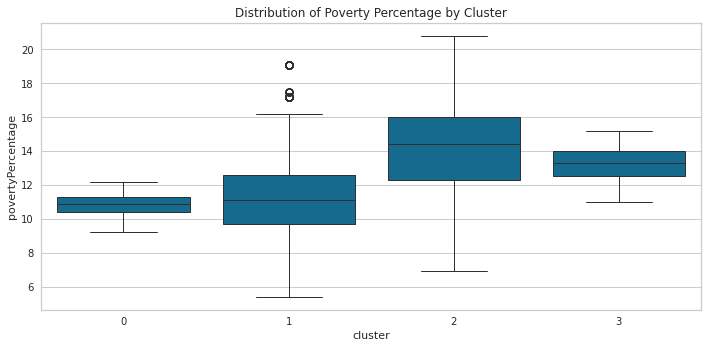

,date,state,city_or_county,latitude,longitude,congressional_district,participant_age_group1,participant_gender1,avg_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,povertyPercentage,party,candidatevotes,totalvotes,ratio_killed,death_level,percentage_injured,unharmed_ratio,density_incident_state,males_to_females_ratio,avg_incident_density_per_district,cluster,cluster_kmeans,cluster_2
91390,2017-01-01,Louisiana,Covington,30.4875,-90.1023,1,Adult 18+,Male,20,0,0,0,0,0,0,1,1,Shots Fired - No Injuries,19.1,REPUBLICAN,243645.0,326788.0,0.0,No deaths,57.850857,10.512655,0.411937,1.0,0.317587,1,1,1
91452,2017-01-01,Louisiana,Baton Rouge,30.4228,-91.1716,6,Adult 18+,Male,27,0,0,0,0,0,1,0,1,Non-Shooting Incident,19.1,REPUBLICAN,207483.0,331098.0,0.0,No deaths,57.850857,10.512655,0.411937,1.0,0.333888,1,1,1
91475,2017-01-01,Mississippi,Meridian,32.3731,-88.6945,3,Adult 18+,Male,25,0,0,0,1,0,0,0,1,"Shot - Dead (murder, accidental, suicide)",19.1,REPUBLICAN,209490.0,316445.0,1.0,All deaths,49.906191,10.512655,0.148595,1.0,0.271355,1,1,1
91695,2017-01-02,Louisiana,Baton Rouge,30.3751,-91.1690,6,Adult 18+,Male,21,0,0,0,0,1,0,0,1,Shot - Wounded/Injured,19.1,REPUBLICAN,207483.0,331098.0,0.0,No deaths,57.850857,10.512655,0.411937,1.0,0.333888,1,1,1
91909,2017-01-04,Louisiana,Houma,29.5950,-90.7305,1,Adult 18+,Male,19,0,0,0,0,0,1,0,1,Shots Fired - No Injuries,19.1,REPUBLICAN,243645.0,326788.0,0.0,No deaths,57.850857,10.512655,0.411937,1.0,0.317587,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133648,2018-03-16,New Mexico,Albuquerque,35.1141,-106.7050,1,Adult 18+,Male,42,0,0,0,1,0,0,0,1,"Shot - Dead (murder, accidental, suicide)",16.2,DEMOCRAT,147336.0,249162.0,1.0,All deaths,46.791444,10.403722,0.062748,1.0,0.317587,1,1,1
133749,2018-03-18,Louisiana,Baton Rouge,30.3891,-91.1730,6,Adult 18+,Male,30,0,0,1,1,0,1,0,2,"Shot - Dead (murder, accidental, suicide)",17.5,REPUBLICAN,186553.0,268525.0,0.5,Some deaths,57.850857,10.403722,0.411937,1.0,0.333888,1,1,1
133916,2018-03-20,New Mexico,Albuquerque,35.0118,-106.7250,1,Teen 12-17,Male,15,0,1,0,1,0,0,0,1,"Shot - Dead (murder, accidental, suicide)",16.2,DEMOCRAT,147336.0,249162.0,1.0,All deaths,46.791444,10.403722,0.062748,1.0,0.317587,1,1,1
134423,2018-03-29,Louisiana,Metairie,29.9916,-90.1558,1,Adult 18+,Male,32,0,0,0,0,0,1,0,1,Non-Shooting Incident,17.5,REPUBLICAN,192555.0,269325.0,0.0,No deaths,57.850857,10.403722,0.411937,1.0,0.317587,1,1,1


In [19]:
# print poverty percentage in each cluster
for clusters in df_merged['cluster'].unique():
    print(f'Cluster {clusters} has a poverty percentage of {df_merged[df_merged["cluster"] == clusters]["povertyPercentage"].mean()}')
    
    
# Plot the distribution of the cluster agains poverty percentage
plt.figure(figsize=(10, 5))
sns.boxplot(x='cluster', y='povertyPercentage', data=df_merged)
plt.title('Distribution of Poverty Percentage by Cluster')
plt.tight_layout()
plt.show()

# get the row where there is an outlier in cluster 1
df_merged[(df_merged['cluster'] == 1) & (df_merged['povertyPercentage'] > 16)]


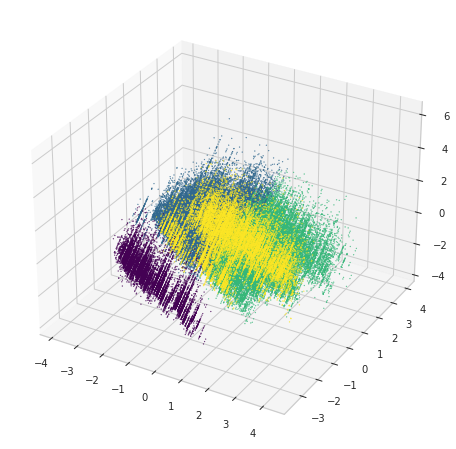

In [20]:



from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca_3['PC1'], df_pca_3['PC2'], df_pca_3['PC3'], alpha=0.7, 
           c=df_merged['cluster'],  s=1, cmap='viridis')

plt.show()

# Consideration about the four clusters


Now we can analyze our 4 cluster and see what are the relationships with the different features.

<AxesSubplot:xlabel='cluster_kmeans', ylabel='count'>

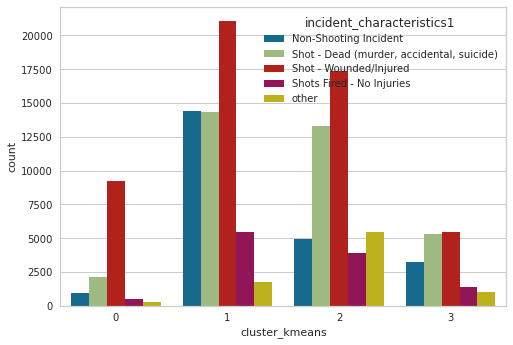

In [21]:
# analyzing distribution of feature "indcident_characteristics1"

#import sns
import seaborn as sns

sns.countplot(data = df_merged, x = 'cluster_kmeans', hue = 'incident_characteristics1')

<AxesSubplot:xlabel='cluster_kmeans', ylabel='count'>

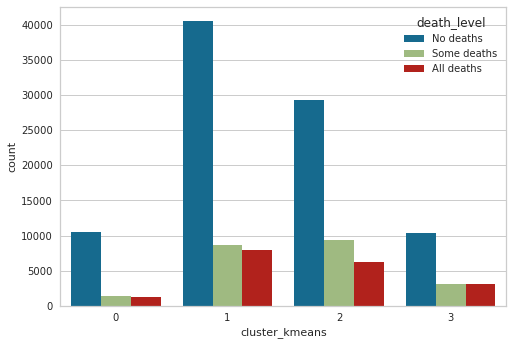

In [22]:
# analyzing distribution of feature death_level

sns.countplot(data = df_merged, x = 'cluster_kmeans', hue = 'death_level')

# KDE plot for the clusters

In [23]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES

import warnings
np.warnings = warnings

[[-0.38853477  1.11644884]
 [-2.62877081  0.80393073]
 [ 0.4961967   1.2837249 ]
 ...
 [-0.30603933  0.03117013]
 [ 1.49911049 -0.22654536]
 [-1.60969964 -2.57476783]]
[[3, 6, 8, 9, 12, 16, 18, 19, 23, 26, 29, 30, 32, 33, 41, 42, 48, 50, 52, 54, 57, 58, 60, 64, 66, 71, 75, 79, 83, 84, 85, 87, 88, 91, 99, 104, 107, 108, 109, 115, 116, 119, 120, 124, 125, 134, 137, 139, 144, 151, 157, 159, 161, 166, 169, 170, 173, 175, 181, 182, 184, 188, 189, 191, 193, 194, 199, 202, 203, 205, 207, 208, 209, 211, 213, 214, 223, 225, 227, 229, 230, 237, 239, 240, 245, 248, 252, 253, 256, 258, 261, 263, 271, 278, 282, 283, 284, 285, 298, 303, 305, 310, 313, 314, 315, 316, 317, 318, 319, 321, 325, 327, 333, 334, 335, 339, 342, 348, 353, 354, 359, 360, 361, 362, 363, 364, 365, 371, 377, 378, 379, 383, 388, 389, 391, 395, 397, 398, 401, 405, 407, 409, 414, 417, 418, 419, 420, 424, 426, 433, 434, 436, 440, 444, 447, 452, 463, 464, 465, 467, 472, 473, 478, 479, 484, 489, 491, 498, 500, 502, 503, 506, 510, 513,

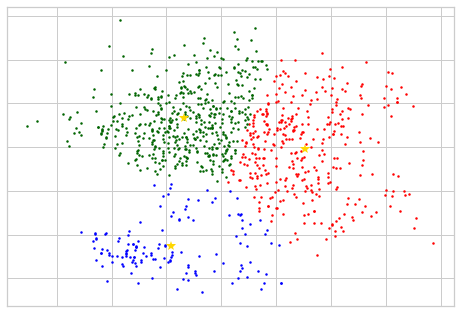

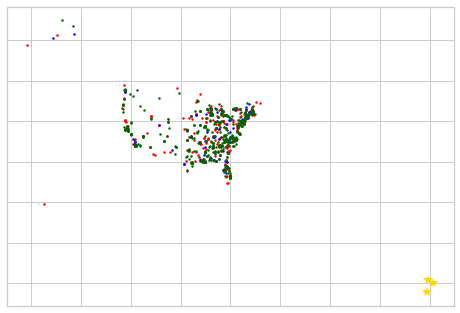

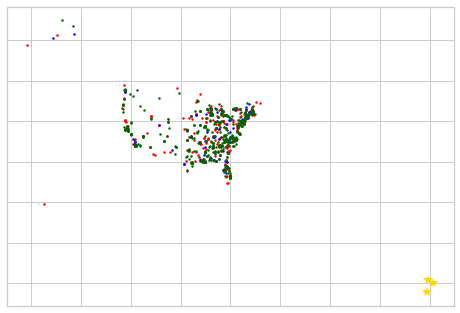

In [24]:
import numpy as np
import warnings
np.warnings = warnings
# Read sample 'simple3' from file.
#sample = read_sample(SIMPLE_SAMPLES.SAMPLE_SIMPLE3)#
#sample = np.array(df_pca)#df_scaled_clustering
df_pca = df_pca.sample(1000)
sample = df_pca.to_numpy()
print(sample)

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(sample, amount_initial_centers).initialize()
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(sample, initial_centers, 20)
xmeans_instance.process()
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
print(clusters)
# Visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show()

# now trying to visualize based on latitute and longitude
df_merged = df_merged.sample(1000)
sample = df_merged[['longitude', 'latitude']].to_numpy()

visualizer_w_map = cluster_visualizer()
visualizer_w_map.append_clusters(clusters, sample)
visualizer_w_map.append_cluster(centers, None, marker='*', markersize=10)
visualizer_w_map.show()




In [25]:
import numpy as np
import warnings
np.warnings = warnings
# Read sample 'simple3' from file.
#sample = read_sample(SIMPLE_SAMPLES.SAMPLE_SIMPLE3)#
#sample = np.array(df_pca)#df_scaled_clustering
df_pca = df_scaled_clustering
sample = df_pca.to_numpy()
print(sample)

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(sample, amount_initial_centers).initialize()
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(sample, initial_centers, 20)
xmeans_instance.process()
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
print(clusters)



[[ 0.04347974 -1.71504244  0.58506406 ... -1.01976646 -0.33512934
  -0.46949671]
 [-1.11646983 -1.71504244  0.58506406 ...  0.87951621 -0.17525745
   1.86234204]
 [ 1.15125906 -1.71504244 -1.83069576 ... -1.16745093  0.38429416
  -0.71495342]
 ...
 [ 0.04853899  1.1028047  -0.62281585 ... -0.6389147  -0.9746169
  -0.46949671]
 [-0.037335    1.1028047  -0.62281585 ...  0.01988954 -0.73480907
  -0.71495342]
 [ 0.16556614  1.1028047  -0.62281585 ... -0.61047966 -0.81474501
  -0.10131164]]
[[6, 7, 13, 15, 17, 22, 23, 30, 32, 33, 36, 40, 49, 53, 64, 71, 74, 76, 84, 95, 97, 98, 100, 104, 107, 109, 114, 118, 121, 128, 133, 134, 135, 136, 137, 138, 141, 142, 143, 158, 160, 162, 176, 180, 183, 187, 200, 210, 212, 221, 222, 225, 236, 240, 247, 249, 256, 257, 262, 266, 268, 269, 278, 287, 297, 302, 303, 306, 315, 318, 323, 327, 328, 329, 330, 335, 336, 338, 339, 341, 349, 355, 357, 358, 360, 362, 368, 373, 380, 391, 394, 395, 401, 405, 406, 411, 413, 417, 418, 422, 425, 426, 428, 440, 441, 443, 4